In [1]:
%reload_ext autoreload

In [2]:
%autoreload
import pandas as pd
import numpy as np
from mvlearn.embed import MCCA
import umap

from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_target_prediction
from src.constants import RANDOM_STATE, CANCER_SUBTYPE_FEATURE
from src.pipelines import subtype_classification_pipeline_cv
from src.autoencoder import EncoderPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2024-05-22 08:46:01.206246: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 08:46:01.244260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 08:46:01.244299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 08:46:01.245376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 08:46:01.252452: I tensorflow/core/platform/cpu_feature_guar

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
dna_breast = pd.read_csv('data/breast/expression_data_breast_for_subtype_pred.csv', index_col=[0])

rna_breast = pd.read_csv('data/breast/mirna_data_breast_for_subtype_pred.csv', index_col=[0])

methylation_breast = pd.read_csv('data/breast/methylation_data_breast_for_subtype_pred.csv', index_col=[0])

mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast_for_subtype_pred.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast_for_subtype_pred.csv')

cancer_subtype = pd.DataFrame(clinical_data_breast[CANCER_SUBTYPE_FEATURE])

In [4]:
N_FACTORS = 20
TRAIN_INDICES, TEST_INDICES = split_patients_for_target_prediction(cancer_subtype, stratify_by=CANCER_SUBTYPE_FEATURE)

Из клинических данных вручную отобраны фичи, которые не связаны с таргетом, содержат более 80% непустых данных и более 1 уникального значения, и которые не являются техническими (названия файлов, идентификаторы и прочее)

In [5]:
CATEGORICAL_CLINICAL_FEATURES = [
                                 'anatomic_neoplasm_subdivision', 
                                 'axillary_lymph_node_stage_method_type',
                                 'breast_carcinoma_estrogen_receptor_status',
                                 'breast_carcinoma_progesterone_receptor_status',
                                 'breast_carcinoma_surgical_procedure_name',
                                 'gender',
                                 'history_of_neoadjuvant_treatment',
                                 'icd_10',
                                 'icd_o_3_site',
                                 'initial_pathologic_diagnosis_method',
                                 'lab_proc_her2_neu_immunohistochemistry_receptor_status',
                                 'margin_status',
                                 'menopause_status',
                                 'new_tumor_event_after_initial_treatment',
                                 'oct_embedded',
                                 'pathologic_M',
                                 'pathologic_N',
                                 'pathologic_T',
                                 'pathologic_stage',
                                 'person_neoplasm_cancer_status',
                                 'primary_lymph_node_presentation_assessment',
                                 'radiation_therapy',
                                 'system_version',
                                 'tissue_prospective_collection_indicator',
                                 'tissue_retrospective_collection_indicator',
                                 'tissue_source_site']
NUMERICAL_CLINICAL_FEATURES = ['age_at_initial_pathologic_diagnosis',
                               'initial_weight', 'lymph_node_examined_count', 'number_of_lymphnodes_positive_by_he']
N_CATEGORICAL_CLINICAL = len(CATEGORICAL_CLINICAL_FEATURES)
N_NUMERIC_CLINICAL = len(NUMERICAL_CLINICAL_FEATURES)

In [6]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in CATEGORICAL_CLINICAL_FEATURES:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features.head()

,age_at_initial_pathologic_diagnosis,initial_weight,lymph_node_examined_count,number_of_lymphnodes_positive_by_he,anatomic_neoplasm_subdivision,axillary_lymph_node_stage_method_type,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,breast_carcinoma_surgical_procedure_name,gender,...,pathologic_N,pathologic_T,pathologic_stage,person_neoplasm_cancer_status,primary_lymph_node_presentation_assessment,radiation_therapy,system_version,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site
0,55.0,60.0,13.0,4.0,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,NX,TX,Stage X,WITH TUMOR,YES,NO,6th,NO,YES,3C
1,50.0,120.0,15.0,1.0,Right Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Lumpectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,YES,6th,NO,YES,3C
2,62.0,NaN,23.0,1.0,Right,missing,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,NO,7th,NO,YES,3C
3,52.0,140.0,2.0,0.0,Right,Sentinel node biopsy alone,Positive,Positive,Simple Mastectomy,FEMALE,...,N0 (i+),T1c,Stage IA,TUMOR FREE,YES,NO,7th,NO,YES,3C
4,50.0,770.0,14.0,4.0,Left|Left Upper Outer Quadrant,Axillary lymph node dissection alone,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N2a,T2,Stage IIIA,TUMOR FREE,YES,NO,7th,YES,NO,4H


In [7]:
X_all = np.hstack([dna_breast.values, rna_breast.values, methylation_breast.values])
X_all_sep = [dna_breast.values, rna_breast.values, methylation_breast.values]

y_all = cancer_subtype.values

In [8]:
pipeline_base_args_cv = [X_all, y_all, clinical_features, RANDOM_STATE,  X_all.shape[1],
                    N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

pipeline_args_cv = [X_all, y_all, clinical_features, RANDOM_STATE, N_FACTORS,
                    N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

## Классификация: предсказание гистологического типа рака груди

### Бейзлайн: без факторизации

In [9]:
%autoreload

base_metrics = subtype_classification_pipeline_cv(None, *pipeline_base_args_cv, plot_feat_imp=False)
f_f_base, f_c_base = base_metrics.values()

KeyboardInterrupt: 

In [ ]:
f_f_base, f_c_base = base_metrics.values()

### MOFA


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        



No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='DNA' with N=614 samples and D=1281 features...
Loaded group='single_group' view='Methylation' with N=614 samples and D=1148 features...
Loaded group='single_group' view='RNA' with N=614 samples and D=182 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (DNA): gaussian
- View 1 (Methylation): gaussian
- View 2 (RNA): gaussian




######################################
## Training the model with seed 42 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in data/outputs/test_1716362694.7318423.hdf5...

        ##############################################

Метрики предсказания по факторам  \
  Infiltrating Ductal Carcinoma f1-score   
0                               0.819277   
1                               0.863636   
2                               0.805195   
3                               0.844444   
4                               0.790123   
5                               0.823529   
6                               0.823529   
7                               0.878049   
8                               0.864198   
9                               0.837209   

                                           \
  Infiltrating Lobular Carcinoma f1-score   
0                                0.685714   
1                                0.758621   
2                                0.731707   
3                                0.620690   
4                                0.666667   
5                                0.689655   
6                                0.740741   
7                                0.764706   
8                                0.787879   
9                                0.689655   

                                                                         \
  Mixed Histology (please specify) f1-score Mucinous Carcinoma f1-score   
0                                       0.0                         0.0   
1                                       0.0                         0.0   
2                                       0.0                         0.0   
3                                       NaN                         NaN   
4                                       0.0                         1.0   
5                                       0.0                         0.4   
6                                       0.0                         0.0   
7                                       0.0                         1.0   
8                                       0.0                         0.8   
9                                       0.0                         0.0   

                                                                    \
  Other, specify f1-score macro avg f1-score weighted avg f1-score   
0                     0.0           0.300998              0.714430   
1                     0.0           0.324451              0.740722   
2                     0.0           0.307380              0.701197   
3                     0.0           0.366284              0.722210   
4                     0.0           0.492798              0.653410   
5                     0.0           0.382637              0.729279   
6                     0.0           0.260712              0.670881   
7                     0.0           0.528551              0.801562   
8                     NaN           0.490415              0.796018   
9                     0.0           0.254477              0.711320   

                                  \
  Metaplastic Carcinoma f1-score   
0                            NaN   
1                            NaN   
2                            NaN   
3                            0.0   
4                            0.5   
5                            NaN   
6                            0.0   
7                            NaN   
8                            0.0   
9                            0.0   

  Метрики предсказания по факторам и клиническим данным  \
                 Infiltrating Ductal Carcinoma f1-score   
0                                           0.833333      
1                                           0.853933      
2                                           0.825000      
3                                           0.857143      
4                                           0.800000      
5                                           0.867470      
6                                           0.831461      
7                                           0.853659      
8                                           0.839506      
9                                           0.843373      

                                           \
  Infiltr

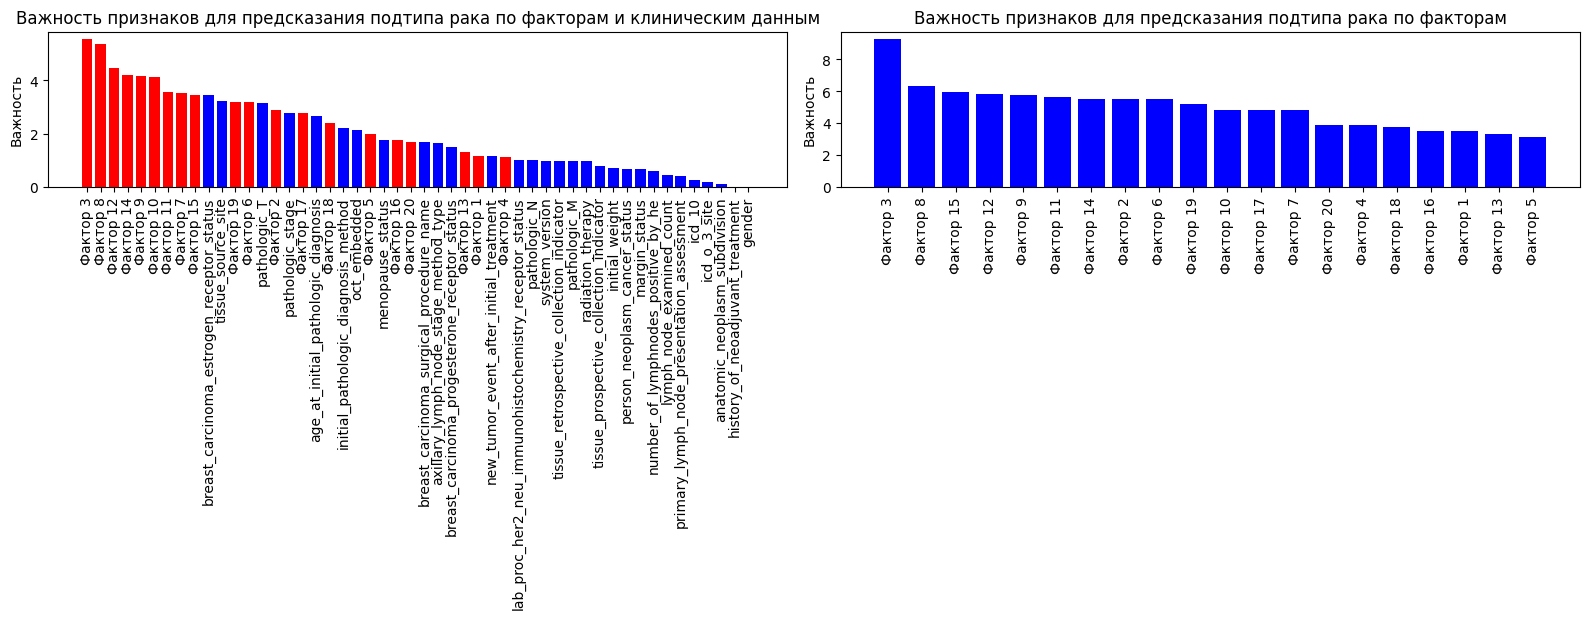

In [10]:
%autoreload

mofa_metrics = subtype_classification_pipeline_cv(train_mofa, *pipeline_args_cv, mofa_dataset=mofa_data_breast)

In [11]:
f_f_mofa, f_c_mofa = mofa_metrics.values()

### MCCA

Метрики предсказания по факторам  \
  Infiltrating Ductal Carcinoma f1-score   
0                               0.813953   
1                               0.844444   
2                               0.769231   
3                               0.827586   
4                               0.738095   
5                               0.814815   
6                               0.837209   
7                               0.891566   
8                               0.853659   
9                               0.785714   

                                           \
  Infiltrating Lobular Carcinoma f1-score   
0                                0.625000   
1                                0.666667   
2                                0.650000   
3                                0.625000   
4                                0.480000   
5                                0.687500   
6                                0.800000   
7                                0.823529   
8                                0.687500   
9                                0.580645   

                                                                         \
  Mixed Histology (please specify) f1-score Mucinous Carcinoma f1-score   
0                                       0.0                    0.666667   
1                                       0.0                    0.000000   
2                                       0.0                    0.000000   
3                                       NaN                         NaN   
4                                       0.0                    1.000000   
5                                       0.0                    0.666667   
6                                       0.0                    0.000000   
7                                       0.0                    1.000000   
8                                       0.0                    0.800000   
9                                       0.0                    0.000000   

                                                                    \
  Other, specify f1-score macro avg f1-score weighted avg f1-score   
0                     0.0           0.421124              0.714960   
1                     0.0           0.302222              0.706093   
2                     0.0           0.283846              0.652481   
3                     0.0           0.363147              0.711833   
4                     0.0           0.369683              0.562748   
5                     0.0           0.433796              0.736149   
6                     0.0           0.272868              0.692032   
7                     0.0           0.543019              0.828305   
8                     NaN           0.468232              0.760006   
9                     0.0           0.394393              0.664312   

                                  \
  Metaplastic Carcinoma f1-score   
0                            NaN   
1                            NaN   
2                            NaN   
3                            0.0   
4                            0.0   
5                            NaN   
6                            0.0   
7                            NaN   
8                            0.0   
9                            1.0   

  Метрики предсказания по факторам и клиническим данным  \
                 Infiltrating Ductal Carcinoma f1-score   
0                                           0.823529      
1                                           0.853933      
2                                           0.784810      
3                                           0.838710      
4                                           0.800000      
5                                           0.850000      
6                                           0.823529      
7                                           0.867470      
8                                           0.853659      
9                                           0.776471      

                                           \
  Infiltr

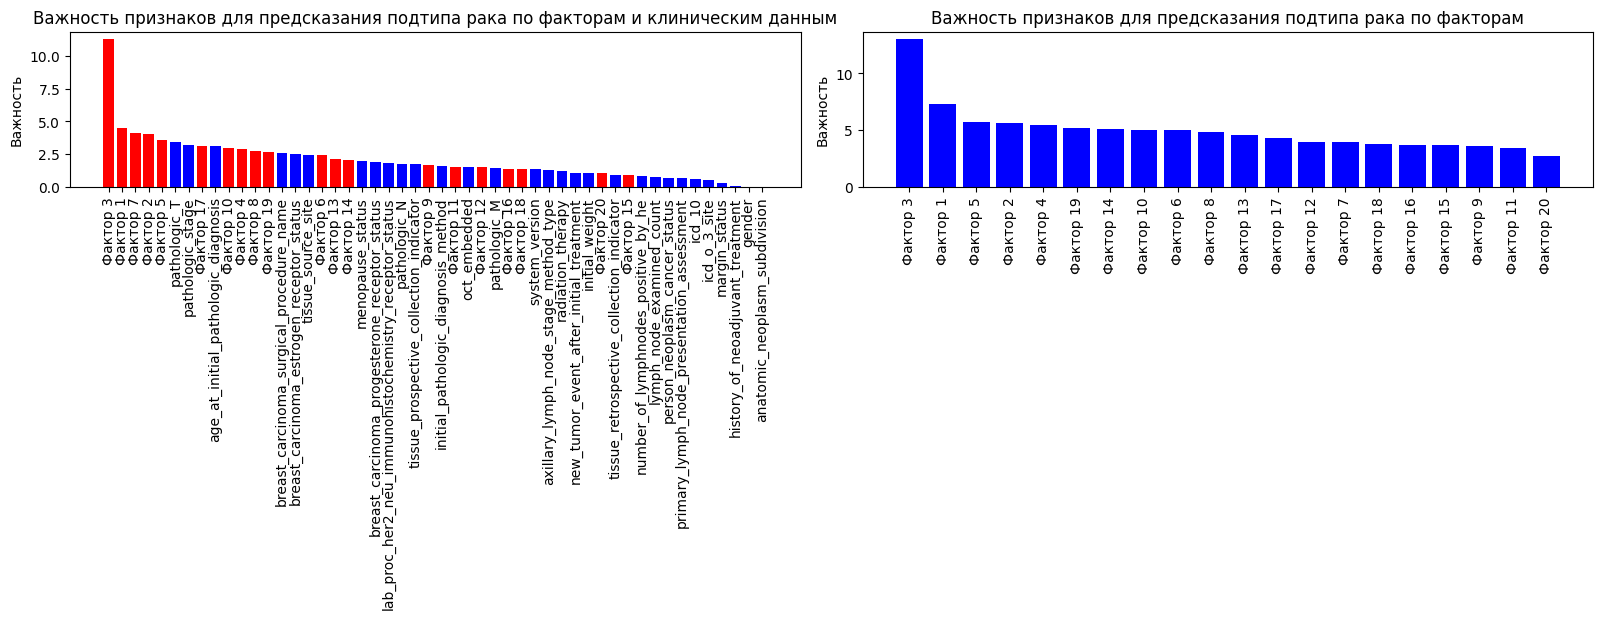

In [12]:
%autoreload

cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_metrics = subtype_classification_pipeline_cv(cca, X_all_sep, *pipeline_args_cv[1:])

f_f_mcca, f_c_mcca = mcca_metrics.values()

### PCA

Метрики предсказания по факторам  \
  Infiltrating Ductal Carcinoma f1-score   
0                               0.776471   
1                               0.840909   
2                               0.810127   
3                               0.851064   
4                               0.775000   
5                               0.813953   
6                               0.843373   
7                               0.867470   
8                               0.902439   
9                               0.839506   

                                           \
  Infiltrating Lobular Carcinoma f1-score   
0                                0.545455   
1                                0.689655   
2                                0.717949   
3                                0.640000   
4                                0.689655   
5                                0.666667   
6                                0.758621   
7                                0.764706   
8                                0.875000   
9                                0.764706   

                                                                         \
  Mixed Histology (please specify) f1-score Mucinous Carcinoma f1-score   
0                                       0.0                         0.0   
1                                       0.0                         0.0   
2                                       0.0                         0.0   
3                                       NaN                         NaN   
4                                       0.0                         1.0   
5                                       0.0                         0.0   
6                                       0.0                         0.0   
7                                       0.0                         1.0   
8                                       0.0                         0.8   
9                                       0.0                         0.0   

                                                                    \
  Other, specify f1-score macro avg f1-score weighted avg f1-score   
0                     0.0           0.264385              0.646783   
1                     0.0           0.306113              0.709374   
2                     0.0           0.305615              0.699019   
3                     0.0           0.372766              0.731366   
4                     0.0           0.410776              0.623544   
5                     0.0           0.296124              0.697674   
6                     0.0           0.266999              0.687053   
7                     0.0           0.526435              0.794972   
8                     NaN           0.515488              0.844922   
9                     0.0           0.267369              0.734860   

                                  \
  Metaplastic Carcinoma f1-score   
0                            NaN   
1                            NaN   
2                            NaN   
3                            0.0   
4                            0.0   
5                            NaN   
6                            0.0   
7                            NaN   
8                            0.0   
9                            0.0   

  Метрики предсказания по факторам и клиническим данным  \
                 Infiltrating Ductal Carcinoma f1-score   
0                                           0.843373      
1                                           0.863636      
2                                           0.800000      
3                                           0.851064      
4                                           0.818182      
5                                           0.860465      
6                                           0.823529      
7                                           0.864198      
8                                           0.847059      
9                                           0.833333      

                                           \
  Infiltr

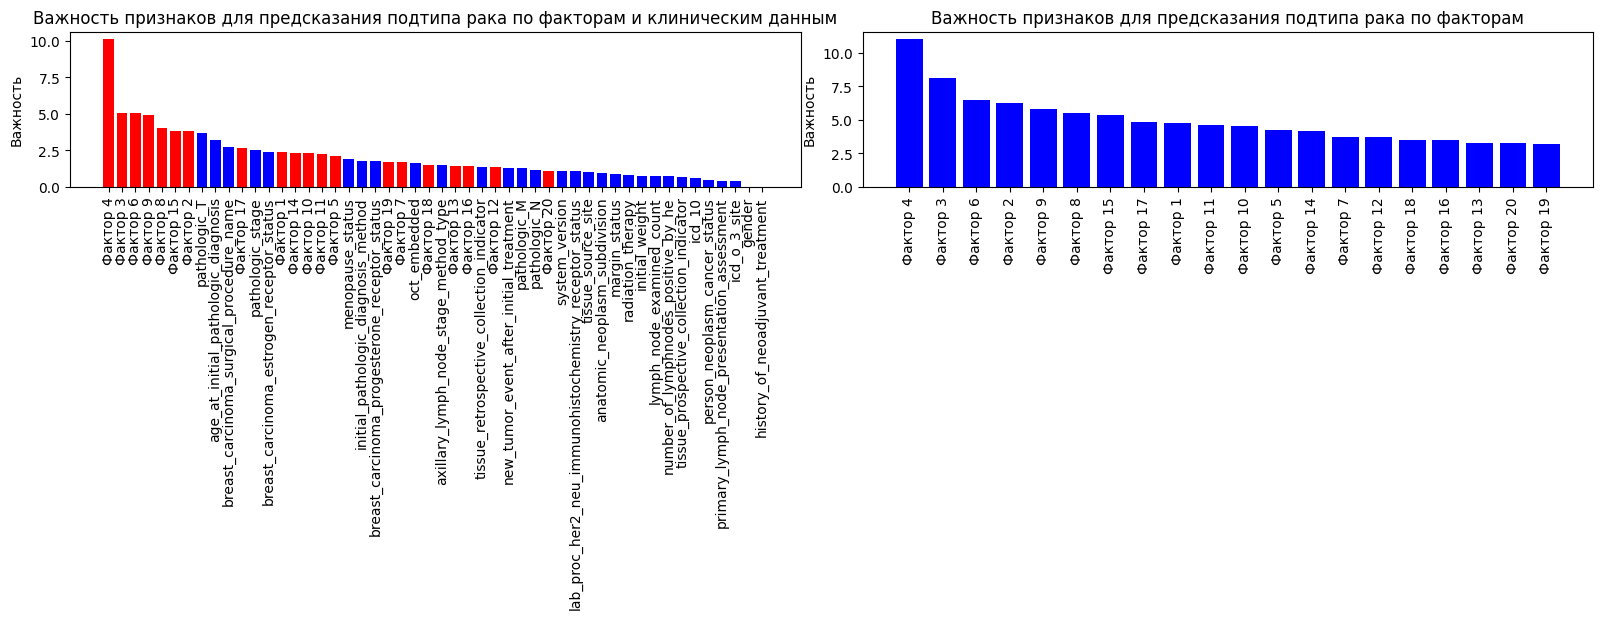

In [13]:
%autoreload

pca = PCA(n_components=N_FACTORS)
pca_metrics = subtype_classification_pipeline_cv(pca, *pipeline_args_cv)

In [14]:
f_f_pca, f_c_pca = pca_metrics.values()

### UMAP

In [15]:
umap_reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_metrics = subtype_classification_pipeline_cv(umap_reducer, *pipeline_args_cv)

In [ ]:
f_f_umap, f_c_umap = umap_metrics.values()

### Base Autoencoder

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Метрики предсказания по факторам  \
  Infiltrating Ductal Carcinoma f1-score   
0                               0.752941   
1                               0.823529   
2                               0.795181   
3                               0.795699   
4                               0.738095   
5                               0.840909   
6                               0.800000   
7                               0.827586   
8                               0.790698   
9                               0.795455   

                                           \
  Infiltrating Lobular Carcinoma f1-score   
0                                0.470588   
1                                0.625000   
2                                0.628571   
3                                0.307692   
4                                0.500000   
5                                0.714286   
6                                0.592593   
7                                0.645161   
8                                0.466667   
9                                0.518519   

                                                                         \
  Mixed Histology (please specify) f1-score Mucinous Carcinoma f1-score   
0                                       0.0                         0.0   
1                                       0.0                         0.0   
2                                       0.0                         0.0   
3                                       NaN                         NaN   
4                                       0.0                         0.0   
5                                       0.0                         0.0   
6                                       0.0                         0.0   
7                                       0.0                         0.0   
8                                       0.0                         0.0   
9                                       0.0                         0.0   

                                                                    \
  Other, specify f1-score macro avg f1-score weighted avg f1-score   
0                     0.0           0.244706              0.610247   
1                     0.0           0.289706              0.682519   
2                     0.0           0.284750              0.659108   
3                     0.0           0.275848              0.613464   
4                     0.0           0.273016              0.569633   
5                     0.0           0.311039              0.727060   
6                     0.0           0.232099              0.624651   
7                     0.0           0.294549              0.716497   
8                     NaN           0.251473              0.617308   
9                     0.0           0.385662              0.651888   

                                  \
  Metaplastic Carcinoma f1-score   
0                            NaN   
1                            NaN   
2                            NaN   
3                            0.0   
4                            0.4   
5                            NaN   
6                            0.0   
7                            NaN   
8                            0.0   
9                            1.0   

  Метрики предсказания по факторам и клиническим данным  \
                 Infiltrating Ductal Carcinoma f1-score   
0                                           0.804878      
1                                           0.818182      
2                                           0.761905      
3                                           0.838710      
4                                           0.772727      
5                                           0.837209      
6                                           0.819277      
7                                           0.840909      
8                                           0.818182      
9                                           0.804598      

                                           \
  Infiltr

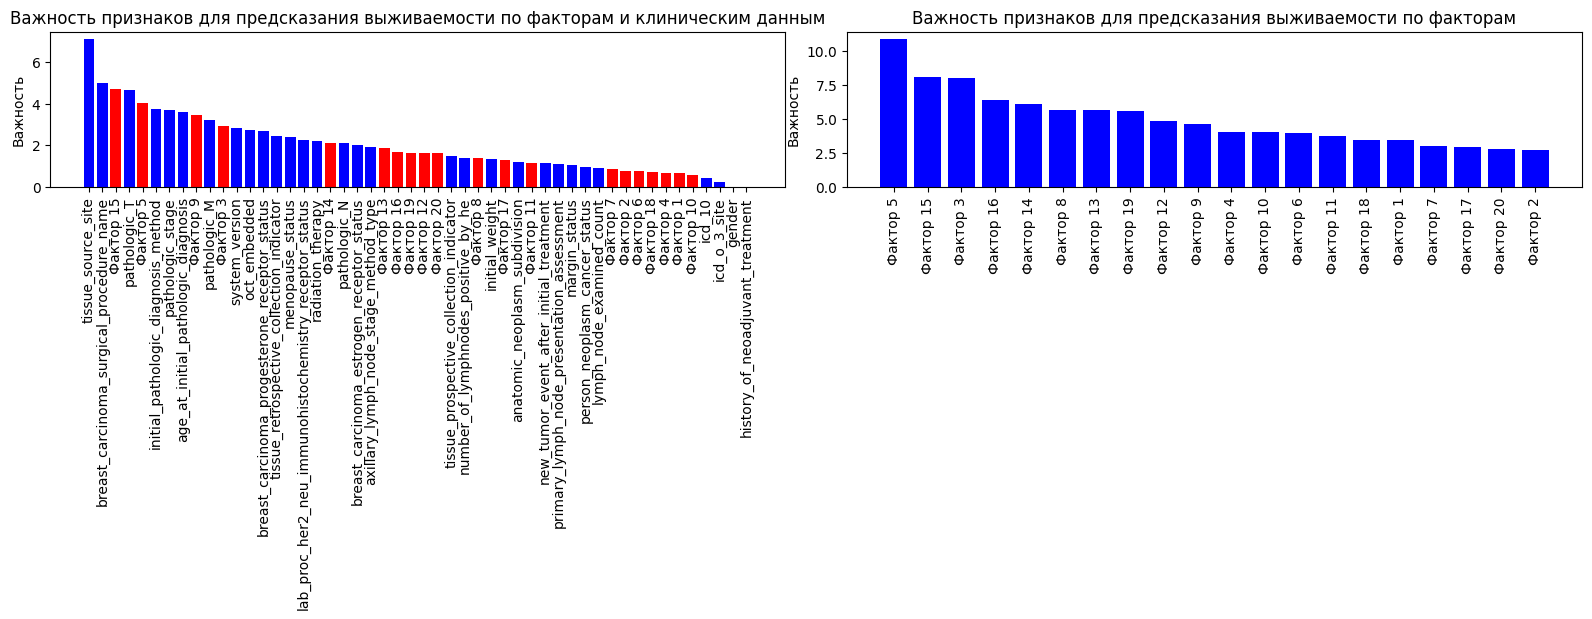

In [ ]:
%autoreload

base_auto_metrics = subtype_classification_pipeline_cv(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:])

In [ ]:
f_f_base_auto, f_c_base_auto = base_auto_metrics.values()

### Triple Autoencoder

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Метрики предсказания по факторам  \
  Infiltrating Ductal Carcinoma f1-score   
0                               0.619718   
1                               0.746667   
2                               0.675676   
3                               0.542857   
4                               0.515152   
5                               0.647887   
6                               0.524590   
7                               0.613333   
8                               0.744186   
9                               0.714286   

                                           \
  Infiltrating Lobular Carcinoma f1-score   
0                                0.458333   
1                                0.476190   
2                                0.454545   
3                                0.367347   
4                                0.227273   
5                                0.488889   
6                                0.352941   
7                                0.372093   
8                                0.333333   
9                                0.400000   

                                                                         \
  Mixed Histology (please specify) f1-score Mucinous Carcinoma f1-score   
0                                       0.0                         0.0   
1                                       0.0                         0.0   
2                                       0.0                         0.0   
3                                       NaN                         NaN   
4                                       0.0                         0.0   
5                                       0.0                         0.0   
6                                       0.0                         0.0   
7                                       0.0                         0.0   
8                                       0.0                         0.0   
9                                       0.0                         0.0   

                                                                    \
  Other, specify f1-score macro avg f1-score weighted avg f1-score   
0                     0.0           0.215610              0.522887   
1                     0.0           0.244571              0.596928   
2                     0.0           0.226044              0.531822   
3                     0.0           0.227551              0.456616   
4                     0.0           0.123737              0.361898   
5                     0.0           0.227355              0.545063   
6                     0.0           0.146255              0.402011   
7                     0.0           0.197085              0.497974   
8                     NaN           0.215504              0.549752   
9                     0.0           0.185714              0.551288   

                                  \
  Metaplastic Carcinoma f1-score   
0                            NaN   
1                            NaN   
2                            NaN   
3                            0.0   
4                            0.0   
5                            NaN   
6                            0.0   
7                            NaN   
8                            0.0   
9                            0.0   

  Метрики предсказания по факторам и клиническим данным  \
                 Infiltrating Ductal Carcinoma f1-score   
0                                           0.752941      
1                                           0.818182      
2                                           0.743590      
3                                           0.822222      
4                                           0.771084      
5                                           0.837209      
6                                           0.743590      
7                                           0.746667      
8                                           0.800000      
9                                           0.761905      

                                           \
  Infiltr

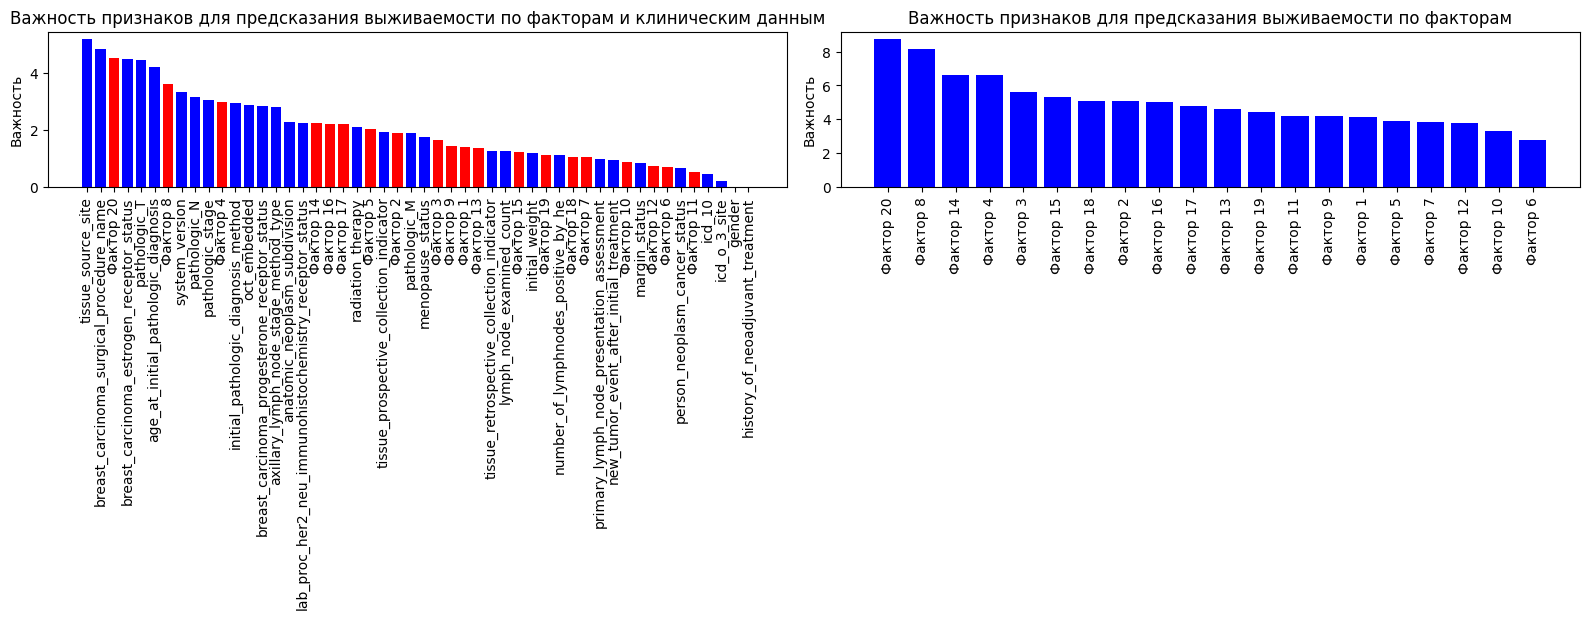

In [ ]:
%autoreload

triple_auto_metrics = subtype_classification_pipeline_cv(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:], base_encoder=False)

In [ ]:
f_f_triple_auto, f_c_triple_auto = base_auto_metrics.values()

### Классификация, результаты:

In [ ]:
subtype_class_results = pd.DataFrame({
    'F1 средневзвешенный предсказания по факторам': [f_f_base, f_f_pca, f_f_umap, f_f_mofa, f_f_mcca, f_f_base_auto, f_f_triple_auto],
    'F1 средневзвешенный предсказания по факторам и клиническим данным': [f_c_base, f_c_pca, f_c_umap, f_c_mofa, f_c_mcca, f_c_base_auto, f_c_triple_auto]
}, index=['Без факторизации', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Базовый автокодировщик', 'Тройной автокодировщик'])

subtype_class_results['Среднее метода'] = subtype_class_results.mean(axis=1)
means = subtype_class_results.iloc[:, :-1].mean(axis=0)
subtype_class_results.loc['Среднее по всем методам'] = means.tolist() + ['-']

subtype_class_results.to_csv('data/subtype_class_results.csv')

subtype_class_results

,F1 средневзвешенный предсказания по факторам,F1 средневзвешенный предсказания по факторам и клиническим данным,Среднее метода
Без факторизации,0.749447,0.740998,0.745223
PCA,0.716957,0.726000,0.721478
UMAP,0.641689,0.679769,0.660729
MOFA,0.724103,0.726560,0.725331
MCCA,0.702892,0.709727,0.706309
Базовый автокодировщик,0.647237,0.668283,0.65776
Тройной автокодировщик,0.647237,0.668283,0.65776
Среднее по всем методам,0.689938,0.702803,-


### *В задаче предсказания гистологического типа по факторам лучше всего оказался PCA и MOFA*

In [ ]:
subtype_class_results

,F1 средневзвешенный предсказания по факторам,F1 средневзвешенный предсказания по факторам и клиническим данным,Среднее метода
Без факторизации,0.749447,0.740998,0.745223
PCA,0.716957,0.726000,0.721478
UMAP,0.641689,0.679769,0.660729
MOFA,0.724103,0.726560,0.725331
MCCA,0.702892,0.709727,0.706309
Базовый автокодировщик,0.647237,0.668283,0.65776
Тройной автокодировщик,0.647237,0.668283,0.65776
Среднее по всем методам,0.689938,0.702803,-


In [ ]:
import pandas as pd
res = pd.read_csv('data/subtype_class_results.csv', index_col=0)
res

,F1 средневзвешенный предсказания по факторам,F1 средневзвешенный предсказания по факторам и клиническим данным,Среднее метода
Без факторизации,0.749447,0.740998,0.7452227068772111
PCA,0.716957,0.726000,0.7214782697661539
UMAP,0.641689,0.679769,0.6607288394864218
MOFA,0.724103,0.726560,0.7253313416463676
MCCA,0.702892,0.709727,0.7063094332515301
Базовый автокодировщик,0.647237,0.668283,0.6577604331763987
Тройной автокодировщик,0.647237,0.668283,0.6577604331763987
Среднее по всем методам,0.689938,0.702803,-
